
## PCA on Occupancy Detection Dataset and Pesticide Dataset

 The goal is to identify the most informative components of the feature space and visualize the explained variance.

### Contents
1. Data Preparation
2. PCA Implementation
3. Variance Explanation
4. Visualizing in Principal Component Space

---


#### Implement PCA function
The function returns:
   1) unit vectors spanning the principal components, and 
   2) the variance captured by each of these components, where the principal components are sorted so that the variance is monotonically decreasing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
    

In [9]:
def pca(X):
    X = (X - np.mean(X, axis = 0))/np.std(X, axis=0)
    cov = np.cov(X.T)
    e_vals,e_vects = np.linalg.eigh(cov)
    
    e_vals = e_vals[::-1]
    e_vects = e_vects[:,::-1]
    
    return e_vects.T, e_vals

Perform PCA on the occupancy dataset OccupancyTrain.csv
\
Visualization: a plot of variance versus PC index

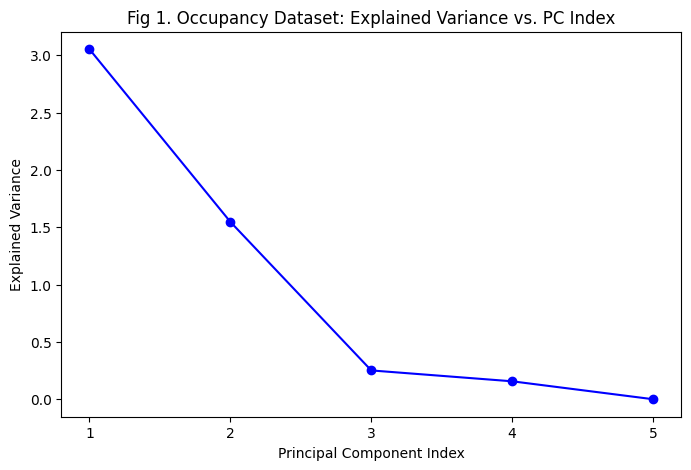

In [10]:
#Perform PCA on the occupancy dataset
occu_train = pd.read_csv('OccupancyTrain.csv', header=None)
X_occu_train = occu_train.iloc[:,:-1].values

unit_vects, explained_vals = pca(X_occu_train)

plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained_vals)+1), explained_vals,marker='o',color='b')
plt.xticks(range(1,len(explained_vals)+1))
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance")
plt.title("Fig 1. Occupancy Dataset: Explained Variance vs. PC Index");


Perform PCA on the pesticide dataset IDSWeedCropTrain.csv. \
Visualization: a plot of variance versus PC index

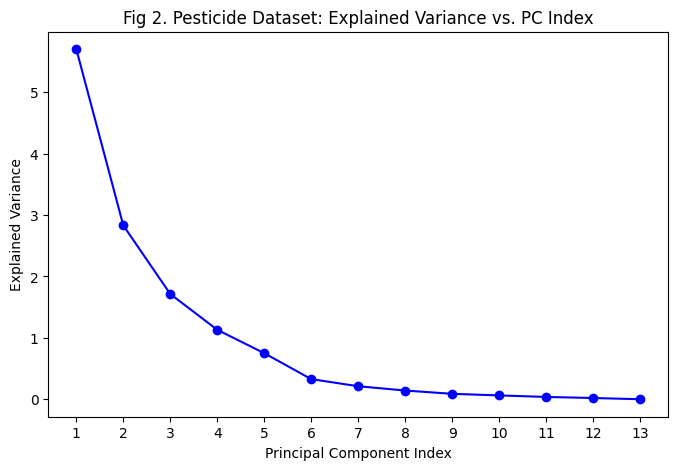

In [11]:
#Perform PCA on the pesticide dataset
weed_train = pd.read_csv('IDSWeedCropTrain.csv', header=None)
X_weed_train = weed_train.iloc[:,:-1].values
y_weed_train = weed_train.iloc[:,-1].values

unit_vects2, explained_vals2 = pca(X_weed_train)

plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained_vals2)+1), explained_vals2,marker='o', color='b')
plt.xticks(range(1,len(explained_vals2)+1))
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance")
plt.title("Fig 2. Pesticide Dataset: Explained Variance vs. PC Index");

Visualization: The cumulative variance versus the index of the PCs

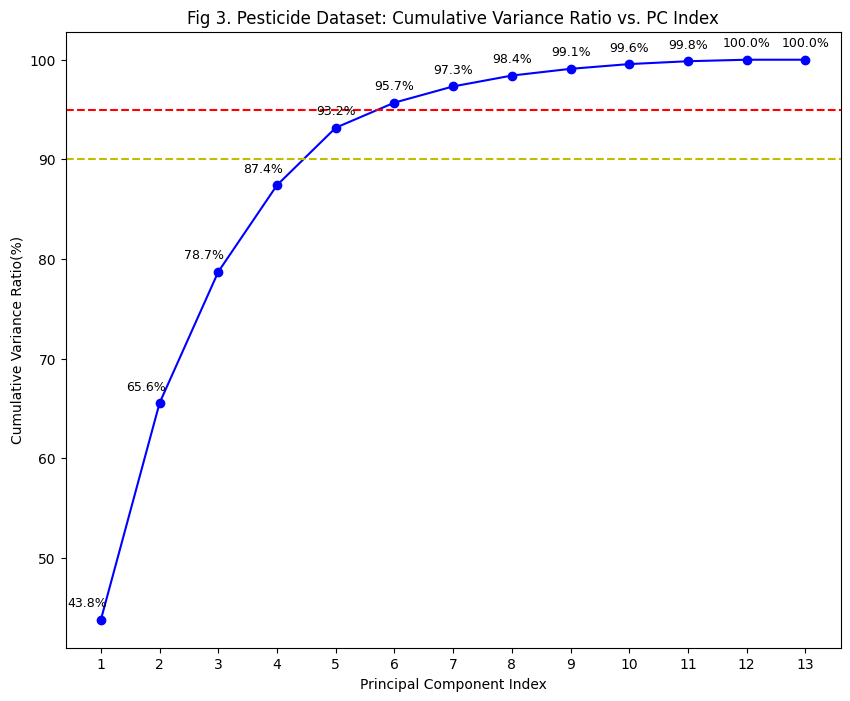

In [12]:
explained_vals2_ratio = explained_vals2 / np.sum(explained_vals2) * 100
cum_variance = np.cumsum(explained_vals2_ratio)
plt.figure(figsize=(10,8))
plt.plot(range(1,len(cum_variance)+1),cum_variance,marker='o',color='b')
plt.xticks(range(1,len(cum_variance)+1))
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Variance Ratio(%)")
plt.title("Fig 3. Pesticide Dataset: Cumulative Variance Ratio vs. PC Index")
plt.axhline(y=90, color='y', linestyle='--', label="90% Variance")
plt.axhline(y=95, color='r', linestyle='--', label="95% Variance")
for i, value in enumerate(cum_variance):
    if(i<4):
        plt.text(i+1.1, value+1, f"{value:.1f}%", ha="right", va="bottom",fontsize=9)
    else:
        plt.text(i+1, value+1, f"{value:.1f}%", ha="center", va="bottom",fontsize=9)


#### Kmeans clustering
- Perform 2-means clustering of the input data in IDSWeedCropTrain.csv. 
- Initialize the cluster centers with the first two data points in IDSWeedCropTrain.csv.


In [21]:
scaler = StandardScaler()
X_weed_trainN = scaler.fit_transform(X_weed_train)

startingPoint = np.vstack((X_weed_trainN[0,],X_weed_trainN[1,]))
kmeans = KMeans(n_clusters=2, init= startingPoint,n_init=1,algorithm='lloyd',random_state=42).fit(X_weed_trainN)
cluster_centers = kmeans.cluster_centers_
train_labels = kmeans.labels_

compare = pd.DataFrame({'Cluster': train_labels, 'True Label': y_weed_train})
cluster_result = compare.groupby('Cluster')['True Label'].value_counts(normalize=True)
center_labels = kmeans.predict(cluster_centers)
for i in range(len(cluster_centers)):
    print(f'Cluster Center: {cluster_centers[i]}, Cluster Label: {center_labels[i]}')
print('Label distribution in Cluster:','\n', cluster_result)


Cluster Center: [ 0.10697804  0.15743643  0.24443175  0.42630232  0.36461238 -0.28733807
 -0.48392646 -0.52535925 -0.49566457 -0.43337993 -0.37703005 -0.26288248
 -0.17762998], Cluster Label: 0
Cluster Center: [-0.26064409 -0.38358222 -0.59553991 -1.03865412 -0.88835112  0.70007797
  1.17905107  1.27999901  1.20765011  1.05589819  0.91860586  0.64049373
  0.43278231], Cluster Label: 1
Label distribution in Cluster: 
 Cluster  True Label
0        1             0.803949
         0             0.196051
1        0             0.996564
         1             0.003436
Name: proportion, dtype: float64


Visualizing in Principal Component Space
- Investigate the data clusters using two pairs of features: Feature 6 and Feature 7, Feature 1 and 2.
- Using scatter plots of test split clusters to investigate which features contribute useful information for clustering

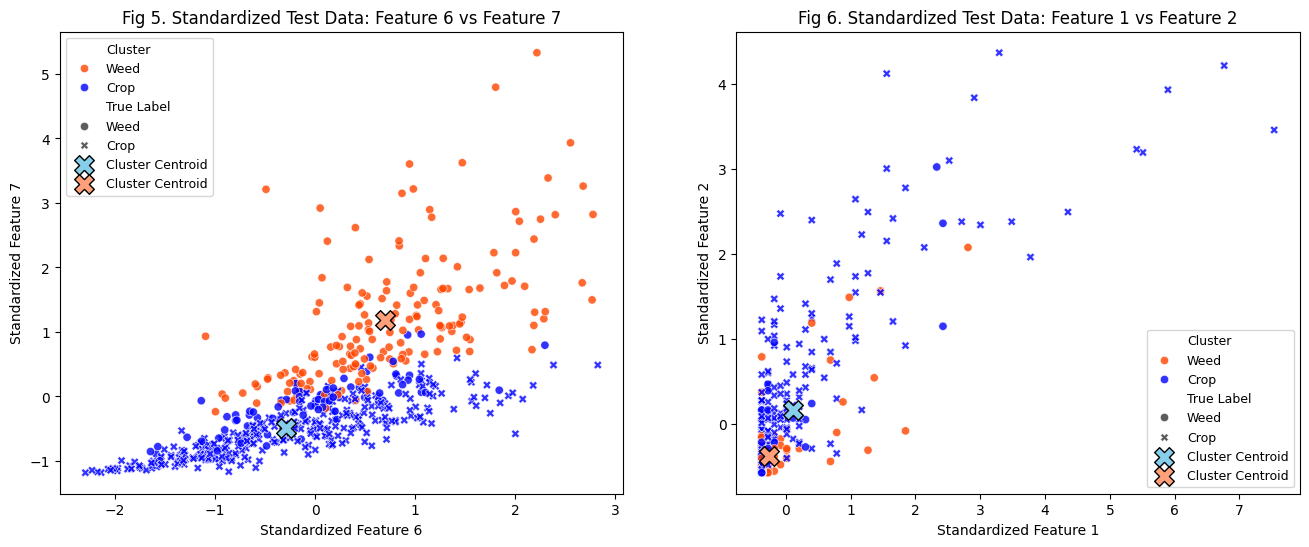

In [24]:
weed_test = pd.read_csv('IDSWeedCropTest.csv', header=None)
X_weed_test = weed_test.iloc[:,:-1].values
y_weed_test = weed_test.iloc[:,-1].values
X_weed_testN = scaler.transform(X_weed_test)
test_labels = kmeans.predict(X_weed_testN)

df = pd.DataFrame({
    'Feature1': X_weed_testN[:, 0],
    'Feature2': X_weed_testN[:, 1],
    'Feature6': X_weed_testN[:, 5],
    'Feature7': X_weed_testN[:, 6],
    'True Label': y_weed_test,
    'Cluster': test_labels
})
df['True Label'] = df['True Label'].map({0: 'Weed', 1: 'Crop'})
df['Cluster'] = df['Cluster'].map({0:'Crop', 1: 'Weed'})
palette = {'Crop': 'blue', 'Weed': 'orangered'}

plt.figure(figsize=(16, 6))

# Plot 1: Feature6 vs Feature7
plt.subplot(1, 2, 1)
scatter1 = sns.scatterplot(x='Feature6', y='Feature7', hue='Cluster', style='True Label', data=df,palette=palette,alpha=0.8)
plt.title('Fig 5. Standardized Test Data: Feature 6 vs Feature 7')
plt.xlabel('Standardized Feature 6')
plt.ylabel('Standardized Feature 7')

palette2 = {0: 'skyblue', 1: 'lightsalmon'}
for i, center in enumerate(cluster_centers):
    plt.scatter(center[5], center[6], s=200, c=palette2[center_labels[i]], marker='X', label=f'Cluster Centroid',edgecolors='black', linewidths=1)
scatter1.legend(loc='upper left',prop={'size': 9})

# Plot 2: Feature1 vs Feature2
plt.subplot(1, 2, 2) 
scatter2 = sns.scatterplot(x='Feature1', y='Feature2', hue='Cluster', style='True Label', data=df ,palette=palette,alpha=0.8)
plt.title('Fig 6. Standardized Test Data: Feature 1 vs Feature 2')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
# Add cluster centers to the plot
for i, center in enumerate(cluster_centers):
    plt.scatter(center[0], center[1], s=200, c=palette2[center_labels[i]], marker='X', label=f'Cluster Centroid', edgecolors='black', linewidths=1)
scatter2.legend(loc='lower right',prop={'size': 9})